## Exploratory Data Analysis
In this section, we explore the structure and trends within the dataset, focusing on salary patterns and skill requirements for data-related roles.

The EDA is structured as follows:
- Dataset Overview
- Summary Statistict
- Analysing Salary Destributions
- Exploring Relationships (Skills vs. Salary)

### Import Libraries

In [11]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load Cleaned Dataset

In [12]:
df = pd.read_pickle(Path.cwd().parents[1] / 'Raw_Data' / 'df_Final_2.pkl')

### Dataset Overview

This section contains general overview of the cleaned dataset, including dataset size, data types, and missing values. This confirms that the dataset is loaded correctly and is suitable for analysis.

In [13]:
df_overview = pd.DataFrame({
    'Data Type': df.dtypes,
    'Missing Values': df.isna().sum()
}).sort_index()

print(f'Dataset shape: {df.shape}')
display(df_overview)

Dataset shape: (42335, 20)


,Data Type,Missing Values
company_name,object,0
country,object,40204
is_eu,bool,0
job_country,object,32
job_health_insurance,bool,0
job_location,object,391
job_no_degree_mention,bool,0
job_posted_date,object,0
job_schedule_type,object,129
job_skills,object,3637


- The dataset contains over **42,300 job postings** with **20 columns** covering job titles, location, salary, and conditions. 
- Most key columns are complete, including salary and job title. About **9%** of **job_skills** values are missing, which will be handled selectively during skill-based analysis.

### Summary Statistics

This section examines summary statistics of key features as salary and job counts.

In [14]:
df['salary_month_avg_eur'].describe().round(0).astype(int)

count    42335
mean      9385
std       3722
min       1146
25%       6845
50%       8831
75%      11493
max      72240
Name: salary_month_avg_eur, dtype: int64

The median salary is approximately **€8,831/month**, indicating wide variability. High-end outliers highlight the importance of robust outlier handling in later modeling and visualizations.

In [15]:
df['job_title_short'].value_counts().head(5)

job_title_short
Data Analyst             11677
Data Scientist           10985
Data Engineer             8143
Senior Data Scientist     2949
Senior Data Engineer      2719
Name: count, dtype: int64

A breakdown of job titles shows the top 2 roles in demand: **Data Analyst**, and **Data Scientist**. These will be our primary focus in the analysis.

### Salary Distributions

Below we compare salary distributions across popular data roles in 2024 using violin plots. This helps visualize central tendencies and outlier behavior by role.

In [16]:
roles_order = ['Data Analyst', 'Senior Data Analyst', 'Data Scientist']
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])

df_filtered = df[
    (df['job_title_short'].isin(roles_order)) &
    (df['job_posted_date'].dt.year == 2024)
].copy()

#### Salary Distribution by Role (2024)

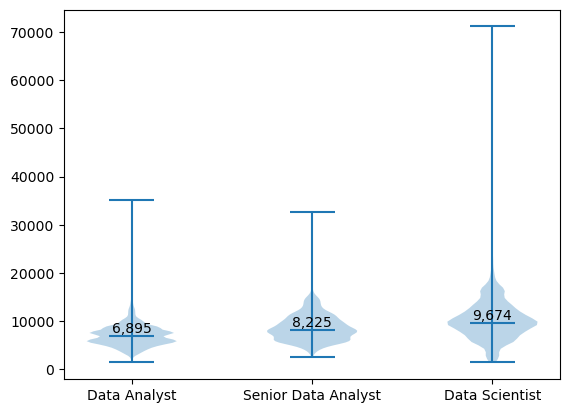

In [17]:
data_by_role = [df_filtered[df_filtered['job_title_short'] == role]['salary_month_avg_eur'] for role in roles_order]

# Plot
fig, ax = plt.subplots()
parts = ax.violinplot(data_by_role, showmedians=True)

for i, data in enumerate(data_by_role):
    median_val = np.median(data)
    ax.text(i + 1, median_val, f"{median_val:,.0f}", ha='center', va='bottom')

ax.set_xticks([1, 2, 3])
ax.set_xticklabels(roles_order)

plt.show()

The **Data Scientist** role offers the highest median salary, even exceeding **Senior Data Analyst**, suggesting a clear compensation advantage and growth opportunity. At the same time Data Scientist salaries show the widest spread, indicating more variability in pay, reflecting differences in specialization, industry, and certainly a skillset.

In [18]:
df_ds_eu = df_filtered[
    (df_filtered['job_title_short'] == 'Data Scientist') &
    (df_filtered['region_group'] == 'EU')
].copy()

#### Top 10 Companies by Salary in Europe (2024)

This plot highlights the top-paying employers for Data Scientists in Europe in 2024. Each bar represents the average monthly salary for the role at that company.

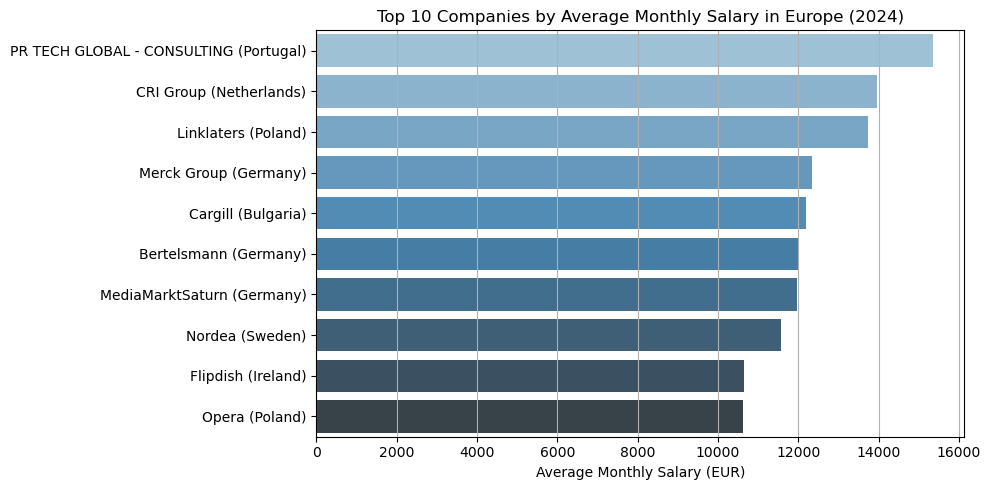

In [19]:
grouped = (
    df_ds_eu
    .groupby(['company_name', 'job_country'])['salary_month_avg_eur']
    .mean()
    .reset_index()
)

grouped['company_label'] = grouped['company_name'] + ' (' + grouped['job_country'] + ')'

top10 = grouped.sort_values("salary_month_avg_eur", ascending=False).head(10)

top10_sorted = top10.sort_values("salary_month_avg_eur", ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(
    data=top10_sorted,
    x='salary_month_avg_eur',
    y='company_label',
    hue='company_label',
    palette='Blues_d',
    legend=False
)

plt.title('Top 10 Companies by Average Monthly Salary in Europe (2024)')
plt.xlabel('Average Monthly Salary (EUR)')
plt.ylabel('')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

The top company offers significantly higher pay than the rest. These insights can help job seekers prioritize applications toward high-compensation employers.

- PR TECH GLOBAL - CONSULTING stands out with salaries over €15K/month, far above the median for DS roles.
- High-paying companies are not concentrated in a single country — instead spanning Western, Northern, and Eastern Europe.
- Germany appears three times, highlighting its competitive market for DS roles.

### Exploring Relationships: Skills vs Salary for Data Scientist Role (2024)

To analyse relationships properly we focus on **Data Scientist** roles, so we can uncover patterns and trends specific to this job title  without the noise from other roles. We investigate whether job postings requiring more skills tend to offer higher salaries.

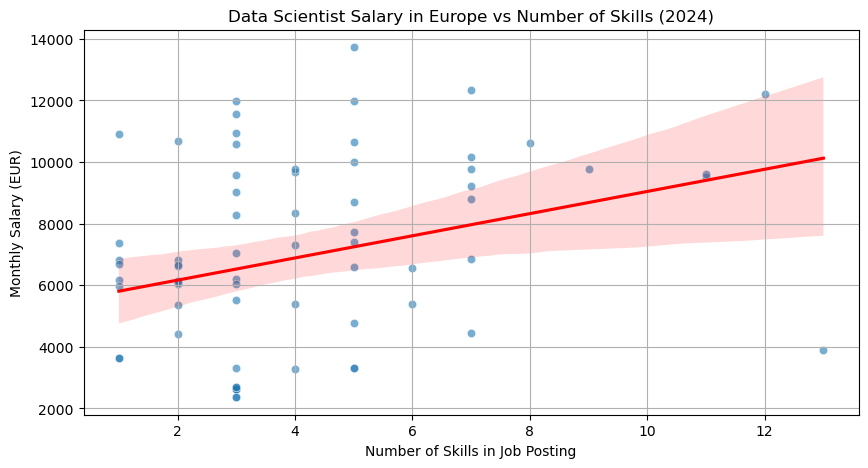

In [20]:
df_skills = df_ds_eu[df_ds_eu['job_skills'].notna()].copy()
df_skills['num_skills'] = df_skills['job_skills'].apply(len)

plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_skills, x='num_skills', y='salary_month_avg_eur', alpha=0.6)
sns.regplot(data=df_skills, x='num_skills', y='salary_month_avg_eur', scatter=False, color='red')
plt.title('Data Scientist Salary in Europe vs Number of Skills (2024)')
plt.xlabel('Number of Skills in Job Posting')
plt.ylabel('Monthly Salary (EUR)')
plt.grid(True)

A regression line (red) shows clear positive trend: more required skills tend to correspond with higher salaries. This supports the idea that broadening skill sets (especially with high-value tools like AWS, Spark, TensorFlow, PyTorch) can boost earning potential.

### Summary
This notebook investigated salary patterns and skill impacts for Data Analyst and Data Scientist roles in Europe, focusing on career transitions between the two.

Main findings:
- Salary Gap – Data Scientists earn ~40% more than Data Analysts, with a wider salary range indicating more specialization-driven pay differences.
- High-Paying Employers – Certain companies, such as PR TECH GLOBAL - CONSULTING and CRI Group, offer salaries significantly above market medians.
- Skills Matter – More required skills correlate with higher pay, especially when including machine learning frameworks and cloud platforms.
- Geographic Insights – Top salaries are geographically diverse, though Germany has a notable concentration of high-paying employers.

Implication for career transitions:
For Data Analysts aiming to move into Data Science, upskilling in specific technical areas (ML frameworks, big data tools, cloud platforms) is a practical route to achieving higher salaries and accessing premium employers.